## Summary of the notebook

## Mount the drive

In [1]:
# mount the drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Setting the correct path

In [2]:
import os


project_path = '/content/drive/MyDrive/MasterThesis'
task_name = 'CaliforniaHousingDatasetTests'
exp_name = 'GBP_explanation'
uncert_name = 'flipout'

%cd /content/drive/MyDrive/MasterThesis/ 

print(os.getcwd())
path = project_path + '/' + task_name + '/' + exp_name + '/' + uncert_name + '/' # 'CaliforniaHousingDatasetTests/GBP_explanation/flipout/'
print('project path ', path)

saved_model_path =  os.path.join(path, 'saved_models')
print('saved_model_path ', saved_model_path)

explanation_path = os.path.join(os.path.dirname(path), 'explanation_files')
explanation_heatmap_path = os.path.join(os.path.dirname(path), 'explanation_heatmaps')

print('explanation_path ', explanation_path)
print('explanation_heatmap ', explanation_heatmap_path)

/content/drive/MyDrive/MasterThesis
/content/drive/MyDrive/MasterThesis
project path  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/
saved_model_path  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/saved_models
explanation_path  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/explanation_files
explanation_heatmap  /content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/explanation_heatmaps


## Install LIME

In [3]:
!pip install lime 
import lime 
import lime.lime_tabular 

!pip show lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 275 kB 4.3 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=34d28ed5114f90bd3aa1a9a11d963322e2259ad4a3e6949945d95a9ed55aebdc
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime
Name: lime
Version: 0.2.0.1
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: /usr/local/lib/python3.7/dist-packages
Requires: scikit-image, scipy, numpy, tqdm, matplotlib, scikit-learn
Required-by: 


## Imports

### LIME specific imports

In [4]:
!pip install pyDOE2 

"""
Functions for explaining classifiers that use tabular data (matrices).
"""
import collections
import copy
from functools import partial
import json
import warnings
from collections import defaultdict

import numpy as np
import scipy as sp
import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from pyDOE2 import lhs
from scipy.stats.distributions import norm
from pathlib import Path
import re


#from lime.discretize import QuartileDiscretizer
#from lime.discretize import DecileDiscretizer
#from lime.discretize import EntropyDiscretizer
#from lime.discretize import BaseDiscretizer
#from lime.discretize import StatsDiscretizer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pyDOE2: filename=pyDOE2-1.3.0-py3-none-any.whl size=25539 sha256=0a3cff69b933857cba9410985439366655a802bfa56ffc02e52c98a40d6aa782
  Stored in directory: /root/.cache/pip/wheels/49/91/2d/d08e80806bf7756193541f6c03c0492af288fcd6158d3d0998
Successfully built pyDOE2


### Other imports

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf

import os
import random 
import math

import seaborn as sns 

from keras.layers import *
from keras.models import Model, Sequential
import keras.backend as K

#tf.compat.v1.disable_eager_execution()
print(tf.__version__)
print(f'Eager execution enabled : {tf.executing_eagerly()}')

import sys
sys.path.insert(0,'/content/drive/My Drive/MasterThesis/src/')

from utils import *

2.8.2
Eager execution enabled : True


## LIME classes 

### LIMEBase

In [6]:
"""
Contains abstract functionality for learning locally linear sparse model.
"""
import numpy as np
import scipy as sp
from sklearn.linear_model import Ridge, lars_path, LinearRegression
from sklearn.utils import check_random_state


class LimeBase(object):
    """Class for learning a locally linear sparse model from perturbed data"""
    def __init__(self,
                 kernel_fn,
                 verbose=True,
                 random_state=None):
        """Init function
        Args:
            kernel_fn: function that transforms an array of distances into an
                        array of proximity values (floats).
            verbose: if true, print local prediction values from linear model.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.kernel_fn = kernel_fn
        self.verbose = verbose
        self.random_state = check_random_state(random_state)

    @staticmethod
    def generate_lars_path(weighted_data, weighted_labels):
        """Generates the lars path for weighted data.
        Args:
            weighted_data: data that has been weighted by kernel
            weighted_label: labels, weighted by kernel
        Returns:
            (alphas, coefs), both are arrays corresponding to the
            regularization parameter and coefficients, respectively
        """
        x_vector = weighted_data
        alphas, _, coefs = lars_path(x_vector,
                                     weighted_labels,
                                     method='lasso',
                                     verbose=False)
        return alphas, coefs

    def forward_selection(self, data, labels, weights, num_features):
        """Iteratively adds features to the model"""
        clf = Ridge(alpha=0, fit_intercept=True, random_state=self.random_state)
        used_features = []
        for _ in range(min(num_features, data.shape[1])):
            max_ = -100000000
            best = 0
            for feature in range(data.shape[1]):
                if feature in used_features:
                    continue
                clf.fit(data[:, used_features + [feature]], labels,
                        sample_weight=weights)
                score = clf.score(data[:, used_features + [feature]],
                                  labels,
                                  sample_weight=weights)
                if score > max_:
                    best = feature
                    max_ = score
            used_features.append(best)
        return np.array(used_features)

    def feature_selection(self, data, labels, weights, num_features, method):
        """Selects features for the model. see explain_instance_with_data to
           understand the parameters."""
        if method == 'none':
            return np.array(range(data.shape[1]))
        elif method == 'forward_selection':
            return self.forward_selection(data, labels, weights, num_features)
        elif method == 'highest_weights':
            clf = Ridge(alpha=0.01, fit_intercept=True,
                        random_state=self.random_state)
            clf.fit(data, labels, sample_weight=weights)

            coef = clf.coef_
            if sp.sparse.issparse(data):
                coef = sp.sparse.csr_matrix(clf.coef_)
                weighted_data = coef.multiply(data[0])
                # Note: most efficient to slice the data before reversing
                sdata = len(weighted_data.data)
                argsort_data = np.abs(weighted_data.data).argsort()
                # Edge case where data is more sparse than requested number of feature importances
                # In that case, we just pad with zero-valued features
                if sdata < num_features:
                    nnz_indexes = argsort_data[::-1]
                    indices = weighted_data.indices[nnz_indexes]
                    num_to_pad = num_features - sdata
                    indices = np.concatenate((indices, np.zeros(num_to_pad, dtype=indices.dtype)))
                    indices_set = set(indices)
                    pad_counter = 0
                    for i in range(data.shape[1]):
                        if i not in indices_set:
                            indices[pad_counter + sdata] = i
                            pad_counter += 1
                            if pad_counter >= num_to_pad:
                                break
                else:
                    nnz_indexes = argsort_data[sdata - num_features:sdata][::-1]
                    indices = weighted_data.indices[nnz_indexes]
                return indices
            else:
                weighted_data = coef * data[0]
                feature_weights = sorted(
                    zip(range(data.shape[1]), weighted_data),
                    key=lambda x: np.abs(x[1]),
                    reverse=True)
                return np.array([x[0] for x in feature_weights[:num_features]])
        elif method == 'lasso_path':
            weighted_data = ((data - np.average(data, axis=0, weights=weights))
                             * np.sqrt(weights[:, np.newaxis]))
            weighted_labels = ((labels - np.average(labels, weights=weights))
                               * np.sqrt(weights))
            nonzero = range(weighted_data.shape[1])
            _, coefs = self.generate_lars_path(weighted_data,
                                               weighted_labels)
            for i in range(len(coefs.T) - 1, 0, -1):
                nonzero = coefs.T[i].nonzero()[0]
                if len(nonzero) <= num_features:
                    break
            used_features = nonzero
            return used_features
        elif method == 'auto':
            if num_features <= 6:
                n_method = 'forward_selection'
            else:
                n_method = 'highest_weights'
            return self.feature_selection(data, labels, weights,
                                          num_features, n_method)

    def explain_instance_with_data(self,
                                   neighborhood_data,
                                   neighborhood_labels,
                                   distances,
                                   label,
                                   num_features,
                                   feature_selection='auto',
                                   model_regressor=None):
        """Takes perturbed data, labels and distances, returns explanation.
        Args:
            neighborhood_data: perturbed data, 2d array. first element is
                               assumed to be the original data point.
            neighborhood_labels: corresponding perturbed labels. should have as
                                 many columns as the number of possible labels.
            distances: distances to original data point.
            label: label for which we want an explanation
            num_features: maximum number of features in explanation
            feature_selection: how to select num_features. options are:
                'forward_selection': iteratively add features to the model.
                    This is costly when num_features is high
                'highest_weights': selects the features that have the highest
                    product of absolute weight * original data point when
                    learning with all the features
                'lasso_path': chooses features based on the lasso
                    regularization path
                'none': uses all features, ignores num_features
                'auto': uses forward_selection if num_features <= 6, and
                    'highest_weights' otherwise.
            model_regressor: sklearn regressor to use in explanation.
                Defaults to Ridge regression if None. Must have
                model_regressor.coef_ and 'sample_weight' as a parameter
                to model_regressor.fit()
        Returns:
            (intercept, exp, score, local_pred):
            intercept is a float.
            exp is a sorted list of tuples, where each tuple (x,y) corresponds
            to the feature id (x) and the local weight (y). The list is sorted
            by decreasing absolute value of y.
            score is the R^2 value of the returned explanation
            local_pred is the prediction of the explanation model on the original instance
        """

        weights = self.kernel_fn(distances)
        labels_column = neighborhood_labels[:, label]
        used_features = self.feature_selection(neighborhood_data,
                                               labels_column,
                                               weights,
                                               num_features,
                                               feature_selection)
        if model_regressor is None:
            model_regressor = Ridge(alpha=1, fit_intercept=True,
                                    random_state=self.random_state)
            #model_regressor = LinearRegression(fit_intercept=True)
        easy_model = model_regressor
        easy_model.fit(neighborhood_data[:, used_features],
                       labels_column, sample_weight=weights)
        prediction_score = easy_model.score(
            neighborhood_data[:, used_features],
            labels_column, sample_weight=weights)

        local_pred = easy_model.predict(neighborhood_data[0, used_features].reshape(1, -1))

        if self.verbose:
            #print('Neighborhood labels ', neighborhood_labels)
            print('Intercept', easy_model.intercept_)
            print('Prediction_local', local_pred,)
            print('Right:', neighborhood_labels[0, label])
            print('coefficients (these are the values that are printed as being the \'weights\' of the feature) ', easy_model.coef_)  # coefficients 
        return (easy_model.intercept_,
                sorted(zip(used_features, easy_model.coef_),
                       key=lambda x: np.abs(x[1]), reverse=True),
                prediction_score, local_pred)

### DomainMapper & Explanation class

In [7]:
"""
Explanation class, with visualization functions.
"""
from io import open
import os
import os.path
import json
import string
import numpy as np

from sklearn.utils import check_random_state


class LimeError(Exception):
    """Raise for errors"""


def id_generator(size=15, random_state=None):
    """Helper function to generate random div ids. This is useful for embedding
    HTML into ipython notebooks."""
    chars = list(string.ascii_uppercase + string.digits)
    return ''.join(random_state.choice(chars, size, replace=True))


class DomainMapper(object):
    """Class for mapping features to the specific domain.
    The idea is that there would be a subclass for each domain (text, tables,
    images, etc), so that we can have a general Explanation class, and separate
    out the specifics of visualizing features in here.
    """

    def __init__(self):
        pass

    def map_exp_ids(self, exp, **kwargs):
        """Maps the feature ids to concrete names.
        Default behaviour is the identity function. Subclasses can implement
        this as they see fit.
        Args:
            exp: list of tuples [(id, weight), (id,weight)]
            kwargs: optional keyword arguments
        Returns:
            exp: list of tuples [(name, weight), (name, weight)...]
        """
        return exp

    def visualize_instance_html(self,
                                exp,
                                label,
                                div_name,
                                exp_object_name,
                                **kwargs):
        """Produces html for visualizing the instance.
        Default behaviour does nothing. Subclasses can implement this as they
        see fit.
        Args:
             exp: list of tuples [(id, weight), (id,weight)]
             label: label id (integer)
             div_name: name of div object to be used for rendering(in js)
             exp_object_name: name of js explanation object
             kwargs: optional keyword arguments
        Returns:
             js code for visualizing the instance
        """
        return ''


class Explanation(object):
    """Object returned by explainers."""

    def __init__(self,
                 domain_mapper,
                 mode='classification',
                 class_names=None,
                 random_state=None,
                 explanation_id=None):
        """
        Initializer.
        Args:
            domain_mapper: must inherit from DomainMapper class
            type: "classification" or "regression"
            class_names: list of class names (only used for classification)
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
        """
        self.random_state = random_state
        self.mode = mode
        self.domain_mapper = domain_mapper
        self.local_exp = defaultdict(list)#
        self.intercept = defaultdict(list)#
        self.score = defaultdict(list)#
        self.local_pred = defaultdict(list)#
        self.explanation_id= explanation_id
        if mode == 'classification':
            self.class_names = class_names
            self.top_labels = None
            self.predict_proba = None
        elif mode == 'regression':
            self.class_names = ['negative', 'positive']
            self.predicted_value = None
            self.min_value = 0.0
            self.max_value = 1.0
            self.dummy_label = 1
        else:
            raise LimeError('Invalid explanation mode "{}". '
                            'Should be either "classification" '
                            'or "regression".'.format(mode))

    def available_labels(self):
        """
        Returns the list of classification labels for which we have any explanations.
        """
        try:
            assert self.mode == "classification"
        except AssertionError:
            raise NotImplementedError('Not supported for regression explanations.')
        else:
            ans = self.top_labels if self.top_labels else self.local_exp.keys()
            return list(ans)

    def as_list(self, label=1, **kwargs):
        """Returns the explanation as a list.
        Args:
            label: desired label. If you ask for a label for which an
                explanation wasn't computed, will throw an exception.
                Will be ignored for regression explanations.
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            list of tuples (representation, weight), where representation is
            given by domain_mapper. Weight is a float.
        """
        label_to_use = label if self.mode == "classification" else self.dummy_label
        ans = self.domain_mapper.map_exp_ids(self.local_exp[label_to_use], **kwargs)
        ans = [(x[0], float(x[1])) for x in ans]
        return ans

    def as_map(self):
        """Returns the map of explanations.
        Returns:
            Map from label to list of tuples (feature_id, weight).
        """
        return self.local_exp

    def as_pyplot_figure(self, label=1, figsize=(4,4), ensemble_component=None, **kwargs):
        """Returns the explanation as a pyplot figure.
        Will throw an error if you don't have matplotlib installed
        Args:
            label: desired label. If you ask for a label for which an
                   explanation wasn't computed, will throw an exception.
                   Will be ignored for regression explanations.
            figsize: desired size of pyplot in tuple format, defaults to (4,4).
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            pyplot figure (barchart).
        """
        import matplotlib.pyplot as plt
        exp = self.as_list(label=label, **kwargs)
        fig = plt.figure(figsize=(8, 5))
        vals = [x[1] for x in exp]
        names = [x[0] for x in exp]
        vals.reverse()
        names.reverse()
        colors = ['C1' if x > 0 else 'C0' for x in vals] # originally negative=red and positive=green (coloring scheme)
        colors_set = set(colors)
        #print('colors_set before ', colors_set)
        colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
        #print('colors_set after ', colors_set)
        pos = np.arange(len(exp)) + .5
        #print('pos values for plot are ', pos)
        #print('vals ', vals)
        #print('names ', names)
        vals_str = [str(round(val, 3)) for val in vals]
        #print('vals_str ', vals_str)
        
        plt.figure(figsize=(8, 5))
        #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

        #colors = ['r', 'g', 'b']
        labels = colors_set 
        legend_colors = list(set(colors))
        #print(legend_colors)
        handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #print(handles)
       
        vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
        #print('vals ', vals)

        for i, v in enumerate(vals):
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/
        axx = plt.barh([i for i in pos], vals, align='center', color=colors, alpha=0.75) # this code appropriate legend
        plt.legend(handles, labels) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

        feat_name = [] 
        
        print('names before ', names)
        for i in names:
            name_list = i.split() 
            for j in name_list:
                #print('j ', j)
                if j[0].isalpha():
                    feat_name.append(j)

        print('names after ', feat_name)

        #plt.yticks(pos, names)
        plt.yticks(pos, feat_name)
        if self.mode == "classification":
            title = 'Local explanation for class %s' % self.class_names[label]
        else:
            #title = 'Local explanation'
            title = 'Explanation ' 
        plt.title(title+' id '+str(self.explanation_id))
        #plt.legend()
        plt.xlabel('feature coefficient')
        plt.grid()
        plt.tight_layout()

        return fig

    def show_in_notebook(self,
                         labels=None,
                         predict_proba=True,
                         show_predicted_value=True,
                         **kwargs):
        """Shows html explanation in ipython notebook.
        See as_html() for parameters.
        This will throw an error if you don't have IPython installed"""

        from IPython.core.display import display, HTML
        display(HTML(self.as_html(labels=labels,
                                  predict_proba=predict_proba,
                                  show_predicted_value=show_predicted_value,
                                  **kwargs)))

    def save_to_file(self,
                     file_path,
                     labels=None,
                     predict_proba=True,
                     show_predicted_value=True,
                     **kwargs):
        """Saves html explanation to file. .
        Params:
            file_path: file to save explanations to
        See as_html() for additional parameters.
        """
        file_ = open(file_path, 'w', encoding='utf8')
        file_.write(self.as_html(labels=labels,
                                 predict_proba=predict_proba,
                                 show_predicted_value=show_predicted_value,
                                 **kwargs))
        file_.close()

    def as_html(self,
                labels=None,
                predict_proba=True,
                show_predicted_value=True,
                **kwargs):
        """Returns the explanation as an html page.
        Args:
            labels: desired labels to show explanations for (as barcharts).
                If you ask for a label for which an explanation wasn't
                computed, will throw an exception. If None, will show
                explanations for all available labels. (only used for classification)
            predict_proba: if true, add  barchart with prediction probabilities
                for the top classes. (only used for classification)
            show_predicted_value: if true, add  barchart with expected value
                (only used for regression)
            kwargs: keyword arguments, passed to domain_mapper
        Returns:
            code for an html page, including javascript includes.
        """

        def jsonize(x):
            return json.dumps(x, ensure_ascii=False)

        if labels is None and self.mode == "classification":
            labels = self.available_labels()


        #this_dir, _ = os.path.split(__file__) # this code gave error that __file__ not defined 
        this_dir = '/usr/local/lib/python3.7/dist-packages/lime/' # intentional hardcoding of the path (for this to work LIME should be installed)
        
        bundle = open(os.path.join(this_dir, 'bundle.js'),
                      encoding="utf8").read()

        out = u'''<html>
        <meta http-equiv="content-type" content="text/html; charset=UTF8">
        <head><script>%s </script></head><body>''' % bundle
        random_id = id_generator(size=15, random_state=check_random_state(self.random_state))
        out += u'''
        <div class="lime top_div" id="top_div%s"></div>
        ''' % random_id

        predict_proba_js = ''
        if self.mode == "classification" and predict_proba:
            predict_proba_js = u'''
            var pp_div = top_div.append('div')
                                .classed('lime predict_proba', true);
            var pp_svg = pp_div.append('svg').style('width', '100%%');
            var pp = new lime.PredictProba(pp_svg, %s, %s);
            ''' % (jsonize([str(x) for x in self.class_names]),
                   jsonize(list(self.predict_proba.astype(float))))

        predict_value_js = ''
        if self.mode == "regression" and show_predicted_value:
            # reference self.predicted_value
            # (svg, predicted_value, min_value, max_value)
            predict_value_js = u'''
                    var pp_div = top_div.append('div')
                                        .classed('lime predicted_value', true);
                    var pp_svg = pp_div.append('svg').style('width', '100%%');
                    var pp = new lime.PredictedValue(pp_svg, %s, %s, %s);
                    ''' % (jsonize(float(self.predicted_value)),
                           jsonize(float(self.min_value)),
                           jsonize(float(self.max_value)))

        exp_js = '''var exp_div;
            var exp = new lime.Explanation(%s);
        ''' % (jsonize([str(x) for x in self.class_names]))

        if self.mode == "classification":
            for label in labels:
                exp = jsonize(self.as_list(label))
                exp_js += u'''
                exp_div = top_div.append('div').classed('lime explanation', true);
                exp.show(%s, %d, exp_div);
                ''' % (exp, label)
        else:
            exp = jsonize(self.as_list())
            exp_js += u'''
            exp_div = top_div.append('div').classed('lime explanation', true);
            exp.show(%s, %s, exp_div);
            ''' % (exp, self.dummy_label)

        raw_js = '''var raw_div = top_div.append('div');'''

        if self.mode == "classification":
            html_data = self.local_exp[labels[0]]
        else:
            html_data = self.local_exp[self.dummy_label]

        raw_js += self.domain_mapper.visualize_instance_html(
                html_data,
                labels[0] if self.mode == "classification" else self.dummy_label,
                'raw_div',
                'exp',
                **kwargs)
        out += u'''
        <script>
        var top_div = d3.select('#top_div%s').classed('lime top_div', true);
        %s
        %s
        %s
        %s
        </script>
        ''' % (random_id, predict_proba_js, predict_value_js, exp_js, raw_js)
        out += u'</body></html>'

        return out

### BaseDiscretizer

In [8]:
"""
Discretizers classes, to be used in lime_tabular
"""
import numpy as np
import sklearn
import sklearn.tree
import scipy
from sklearn.utils import check_random_state
from abc import ABCMeta, abstractmethod


class BaseDiscretizer():
    """
    Abstract class - Build a class that inherits from this class to implement
    a custom discretizer.
    Method bins() is to be redefined in the child class, as it is the actual
    custom part of the discretizer.
    """

    __metaclass__ = ABCMeta  # abstract class

    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None,
                 data_stats=None):
        """Initializer
        Args:
            data: numpy 2d array
            categorical_features: list of indices (ints) corresponding to the
                categorical columns. These features will not be discretized.
                Everything else will be considered continuous, and will be
                discretized.
            categorical_names: map from int to list of names, where
                categorical_names[x][y] represents the name of the yth value of
                column x.
            feature_names: list of names (strings) corresponding to the columns
                in the training data.
            data_stats: must have 'means', 'stds', 'mins' and 'maxs', use this
                if you don't want these values to be computed from data
        """
        #print('Inside BaseDiscretizer __init__')
        self.to_discretize = ([x for x in range(data.shape[1])
                               if x not in categorical_features])
        #print('to_discretize :', self.to_discretize)
        self.data_stats = data_stats
        self.names = defaultdict(list)#    solution taken from https://stackoverflow.com/questions/23297569/python-key-error-0-cant-find-dict-error-in-code 
        self.lambdas = defaultdict(list)#
        self.means = defaultdict(list)#
        self.stds = defaultdict(list)#
        self.mins = defaultdict(list)#
        self.maxs = defaultdict(list)#
        self.random_state = check_random_state(random_state)

        # To override when implementing a custom binning
        bins = self.bins(data, labels)
        bins = [np.unique(x) for x in bins]
        #print('bins :', bins)

        # Read the stats from data_stats if exists
        if data_stats:
            self.means = self.data_stats.get("means")
            self.stds = self.data_stats.get("stds")
            self.mins = self.data_stats.get("mins")
            self.maxs = self.data_stats.get("maxs")

        for feature, qts in zip(self.to_discretize, bins):
            n_bins = qts.shape[0]  # Actually number of borders (= #bins-1)
            #print(f'n_bins for feature ({feature}) \'{feature_names[feature]}\' and qts {qts} is {n_bins}')
            boundaries = np.min(data[:, feature]), np.max(data[:, feature])
            #print(f'boundaries : {boundaries}')
            name = feature_names[feature]
            #print(f'feature_names {name}')

            ###self.names[feature] = ['%s <= %.2f' % (name, qts[0])]
            self.names[feature] = ['%s' % (name)]
            for i in range(n_bins - 1):
                ###self.names[feature].append('%.2f < %s <= %.2f' %
                ###                           (qts[i], name, qts[i + 1]))
                self.names[feature].append('%s' %
                                           (name))
                #print('statements to be added')
                #print('%.2f < %s <= %.2f' %(qts[i], name, qts[i + 1]))

            ###self.names[feature].append('%s > %.2f' % (name, qts[n_bins - 1]))
            self.names[feature].append('%s' % (name))
            #print('statements to be added')
            #print('%s > %.2f' % (name, qts[n_bins - 1]))

            self.lambdas[feature] = lambda x, qts=qts: np.searchsorted(qts, x)    # this is how searchsorted works : np.searchsorted([1,2,3,4,5], 3) : answer-> 2 (shape of output is same as second argument)
            #print(f'lambdas : {self.lambdas[feature]}')
            #print(f'data[:, features] {data[:, feature]}')
            #print(f'qts : {qts}')
            discretized = self.lambdas[feature](data[:, feature])  # all np.searsorted does is attempt to identify those indices where the data[:,features] values could be inserted within the qts array 
            #print('discretized :', discretized)
            #print('len of discretized :', len(discretized))
            # If data stats are provided no need to compute the below set of details
            if data_stats:
                continue

            self.means[feature] = []
            self.stds[feature] = []
            for x in range(n_bins + 1):
                selection = data[discretized == x, feature]
                mean = 0 if len(selection) == 0 else np.mean(selection)
                self.means[feature].append(mean)
                std = 0 if len(selection) == 0 else np.std(selection)
                std += 0.00000000001
                self.stds[feature].append(std)
            self.mins[feature] = [boundaries[0]] + qts.tolist()
            self.maxs[feature] = qts.tolist() + [boundaries[1]]


            #print(f'mins self.mins[feature] {self.mins[feature]}')
            #print(f'maxs self.maxs[feature] {self.maxs[feature]}')

    @abstractmethod
    def bins(self, data, labels):
        """
        To be overridden
        Returns for each feature to discretize the boundaries
        that form each bin of the discretizer
        """
        raise NotImplementedError("Must override bins() method")

    def discretize(self, data):
        """Discretizes the data.
        Args:
            data: numpy 2d or 1d array
        Returns:
            numpy array of same dimension, discretized.
        """
        ret = data.copy()
        for feature in self.lambdas:
            if len(data.shape) == 1:
                ret[feature] = int(self.lambdas[feature](ret[feature]))
            else:
                ret[:, feature] = self.lambdas[feature](
                    ret[:, feature]).astype(int)
        return ret

    def get_undiscretize_values(self, feature, values):
        mins = np.array(self.mins[feature])[values]
        maxs = np.array(self.maxs[feature])[values]

        means = np.array(self.means[feature])[values]
        stds = np.array(self.stds[feature])[values]
        minz = (mins - means) / stds
        maxz = (maxs - means) / stds
        min_max_unequal = (minz != maxz)

        ret = minz
        ret[np.where(min_max_unequal)] = scipy.stats.truncnorm.rvs(
            minz[min_max_unequal],
            maxz[min_max_unequal],
            loc=means[min_max_unequal],
            scale=stds[min_max_unequal],
            random_state=self.random_state
        )
        return ret

    def undiscretize(self, data):
        ret = data.copy()
        for feature in self.means:
            if len(data.shape) == 1:
                ret[feature] = self.get_undiscretize_values(
                    feature, ret[feature].astype(int).reshape(-1, 1)
                )
            else:
                ret[:, feature] = self.get_undiscretize_values(
                    feature, ret[:, feature].astype(int)
                )
        return ret


class StatsDiscretizer(BaseDiscretizer):
    """
        Class to be used to supply the data stats info when discretize_continuous is true
    """

    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None,
                 data_stats=None):

        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state,
                                 data_stats=data_stats)

    def bins(self, data, labels):
        bins_from_stats = self.data_stats.get("bins")
        bins = []
        if bins_from_stats is not None:
            for feature in self.to_discretize:
                bins_from_stats_feature = bins_from_stats.get(feature)
                if bins_from_stats_feature is not None:
                    qts = np.array(bins_from_stats_feature)
                    bins.append(qts)
        return bins


class QuartileDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):

        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            qts = np.array(np.percentile(data[:, feature], [25, 50, 75]))
            bins.append(qts)
        return bins


class DecileDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):
        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            qts = np.array(np.percentile(data[:, feature],
                                         [10, 20, 30, 40, 50, 60, 70, 80, 90]))
            bins.append(qts)
        return bins


class EntropyDiscretizer(BaseDiscretizer):
    def __init__(self, data, categorical_features, feature_names, labels=None, random_state=None):
        if(labels is None):
            raise ValueError('Labels must be not None when using \
                             EntropyDiscretizer')
        BaseDiscretizer.__init__(self, data, categorical_features,
                                 feature_names, labels=labels,
                                 random_state=random_state)

    def bins(self, data, labels):
        bins = []
        for feature in self.to_discretize:
            # Entropy splitting / at most 8 bins so max_depth=3
            dt = sklearn.tree.DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=3,
                                                     random_state=self.random_state)
            x = np.reshape(data[:, feature], (-1, 1))
            dt.fit(x, labels)
            qts = dt.tree_.threshold[np.where(dt.tree_.children_left > -1)]

            if qts.shape[0] == 0:
                qts = np.array([np.median(data[:, feature])])
            else:
                qts = np.sort(qts)

            bins.append(qts)

        return bins

### TableDomainMapperr & LIMETabularExplainer

In [9]:
class TableDomainMapper(DomainMapper):
    """Maps feature ids to names, generates table views, etc"""

    def __init__(self, feature_names, feature_values, scaled_row,
                 categorical_features, discretized_feature_names=None,
                 feature_indexes=None):
        """Init.
        Args:
            feature_names: list of feature names, in order
            feature_values: list of strings with the values of the original row
            scaled_row: scaled row
            categorical_features: list of categorical features ids (ints)
            feature_indexes: optional feature indexes used in the sparse case
        """
        self.exp_feature_names = feature_names
        print('feature_names_here ', self.exp_feature_names)
        self.discretized_feature_names = discretized_feature_names
        self.feature_names = feature_names
        self.feature_values = feature_values
        self.feature_indexes = feature_indexes
        self.scaled_row = scaled_row
        if sp.sparse.issparse(scaled_row):
            self.all_categorical = False
        else:
            self.all_categorical = len(categorical_features) == len(scaled_row)
        self.categorical_features = categorical_features

    def map_exp_ids(self, exp):
        """Maps ids to feature names.
        Args:
            exp: list of tuples [(id, weight), (id,weight)]
        Returns:
            list of tuples (feature_name, weight)
        """
        names = self.exp_feature_names
        if self.discretized_feature_names is not None:
            names = self.discretized_feature_names
        return [(names[x[0]], x[1]) for x in exp]

    def visualize_instance_html(self,
                                exp,
                                label,
                                div_name,
                                exp_object_name,
                                show_table=True,
                                show_all=False):
        """Shows the current example in a table format.
        Args:
             exp: list of tuples [(id, weight), (id,weight)]
             label: label id (integer)
             div_name: name of div object to be used for rendering(in js)
             exp_object_name: name of js explanation object
             show_table: if False, don't show table visualization.
             show_all: if True, show zero-weighted features in the table.
        """
        if not show_table:
            return ''
        weights = [0] * len(self.feature_names)
        for x in exp:
            weights[x[0]] = x[1]
            print_weights = [round(t, 3) for t in weights]
            #print('weights ', print_weights)
        if self.feature_indexes is not None:
            # Sparse case: only display the non-zero values and importances
            fnames = [self.exp_feature_names[i] for i in self.feature_indexes]
            #print('fnames ', fnames)
            fweights = [weights[i] for i in self.feature_indexes]
            #print('fweights ', fweights)
            if show_all:
                out_list = list(zip(fnames,
                                    self.feature_values,
                                    fweights))
            else:
                out_dict = dict(map(lambda x: (x[0], (x[1], x[2], x[3])),
                                zip(self.feature_indexes,
                                    fnames,
                                    self.feature_values,
                                    fweights)))
                out_list = [out_dict.get(x[0], (str(x[0]), 0.0, 0.0)) for x in exp]
        else:
            out_list = list(zip(self.exp_feature_names,
                                self.feature_values,
                                weights))
            if not show_all:
                out_list = [out_list[x[0]] for x in exp]
        ret = u'''
            %s.show_raw_tabular(%s, %d, %s);
        ''' % (exp_object_name, json.dumps(out_list, ensure_ascii=False), label, div_name)
        return ret


class LimeTabularExplainer(object):
    """Explains predictions on tabular (i.e. matrix) data.
    For numerical features, perturb them by sampling from a Normal(0,1) and
    doing the inverse operation of mean-centering and scaling, according to the
    means and stds in the training data. For categorical features, perturb by
    sampling according to the training distribution, and making a binary
    feature that is 1 when the value is the same as the instance being
    explained."""

    def __init__(self,
                 training_data,
                 mode="classification",
                 training_labels=None,
                 feature_names=None,
                 categorical_features=None,
                 categorical_names=None,
                 kernel_width=None,
                 kernel=None,
                 verbose=False,
                 class_names=None,
                 feature_selection='none',
                 discretize_continuous=True,
                 discretizer='quartile',
                 sample_around_instance=False,
                 random_state=None,
                 training_data_stats=None):
        """Init function.
        Args:
            training_data: numpy 2d array
            mode: "classification" or "regression"
            training_labels: labels for training data. Not required, but may be
                used by discretizer.
            feature_names: list of names (strings) corresponding to the columns
                in the training data.
            categorical_features: list of indices (ints) corresponding to the
                categorical columns. Everything else will be considered
                continuous. Values in these columns MUST be integers.
            categorical_names: map from int to list of names, where
                categorical_names[x][y] represents the name of the yth value of
                column x.
            kernel_width: kernel width for the exponential kernel.
                If None, defaults to sqrt (number of columns) * 0.75
            kernel: similarity kernel that takes euclidean distances and kernel
                width as input and outputs weights in (0,1). If None, defaults to
                an exponential kernel.
            verbose: if true, print local prediction values from linear model
            class_names: list of class names, ordered according to whatever the
                classifier is using. If not present, class names will be '0',
                '1', ...
            feature_selection: feature selection method. can be
                'forward_selection', 'lasso_path', 'none' or 'auto'.
                See function 'explain_instance_with_data' in lime_base.py for
                details on what each of the options does.
            discretize_continuous: if True, all non-categorical features will
                be discretized into quartiles.
            discretizer: only matters if discretize_continuous is True
                and data is not sparse. Options are 'quartile', 'decile',
                'entropy' or a BaseDiscretizer instance.
            sample_around_instance: if True, will sample continuous features
                in perturbed samples from a normal centered at the instance
                being explained. Otherwise, the normal is centered on the mean
                of the feature data.
            random_state: an integer or numpy.RandomState that will be used to
                generate random numbers. If None, the random state will be
                initialized using the internal numpy seed.
            training_data_stats: a dict object having the details of training data
                statistics. If None, training data information will be used, only matters
                if discretize_continuous is True. Must have the following keys:
                means", "mins", "maxs", "stds", "feature_values",
                "feature_frequencies"
        """

        #print('Inside __init__ of LimeTabularExplainer')

        self.random_state = check_random_state(random_state)
        self.mode = mode
        self.categorical_names = categorical_names or defaultdict(list)#
        self.sample_around_instance = sample_around_instance
        self.training_data_stats = training_data_stats
    
        
        #print('mode :', self.mode)
        #print('sample_around_instance :', self.sample_around_instance)
        #print('training_data_stats :', self.training_data_stats) 

        # Check and raise proper error in stats are supplied in non-descritized path
        if self.training_data_stats:
            self.validate_training_data_stats(self.training_data_stats)

        if categorical_features is None:
            categorical_features = []
        if feature_names is None:
            feature_names = [str(i) for i in range(training_data.shape[1])]

        self.categorical_features = list(categorical_features)
        self.feature_names = list(feature_names)

        #print('categorical_features :', categorical_features)
        #print('feature_names :', feature_names)
        
        self.discretizer = None
        if discretize_continuous and not sp.sparse.issparse(training_data):
            # Set the discretizer if training data stats are provided
            if self.training_data_stats:
                discretizer = StatsDiscretizer(
                    training_data, self.categorical_features,
                    self.feature_names, labels=training_labels,
                    data_stats=self.training_data_stats,
                    random_state=self.random_state)

            if discretizer == 'quartile':
                self.discretizer = QuartileDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif discretizer == 'decile':
                self.discretizer = DecileDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif discretizer == 'entropy':
                self.discretizer = EntropyDiscretizer(
                        training_data, self.categorical_features,
                        self.feature_names, labels=training_labels,
                        random_state=self.random_state)
            elif isinstance(discretizer, BaseDiscretizer):
                self.discretizer = discretizer
            else:
                raise ValueError('''Discretizer must be 'quartile',''' +
                                 ''' 'decile', 'entropy' or a''' +
                                 ''' BaseDiscretizer instance''')
            self.categorical_features = list(range(training_data.shape[1]))

            #print('discretizer object returned :', self.discretizer) 
            #print('discretizer in use :', discretizer)
            
            # Get the discretized_training_data when the stats are not provided
            if(self.training_data_stats is None):
                #print('training_data_stats are not provided')
                discretized_training_data = self.discretizer.discretize(
                    training_data)

        if kernel_width is None:
            kernel_width = np.sqrt(training_data.shape[1]) * .75
        kernel_width = float(kernel_width)

        #print('kernel_width to be used : ', kernel_width)

        if kernel is None:
            def kernel(d, kernel_width):
                return np.sqrt(np.exp(-(d ** 2) / kernel_width ** 2))

        kernel_fn = partial(kernel, kernel_width=kernel_width)

        self.feature_selection = feature_selection
        self.base = LimeBase(kernel_fn, verbose, random_state=self.random_state)
        #print('LimeBase object :', self.base)
        self.class_names = class_names

        #print('class_names :', class_names)

        # Though set has no role to play if training data stats are provided
        self.scaler = sklearn.preprocessing.StandardScaler(with_mean=False)
        self.scaler.fit(training_data)
        self.feature_values = defaultdict(list)#
        self.feature_frequencies = defaultdict(list)#

        for feature in self.categorical_features:
            if training_data_stats is None:
                if self.discretizer is not None:
                    column = discretized_training_data[:, feature]
                else:
                    column = training_data[:, feature]

                feature_count = collections.Counter(column)
                values, frequencies = map(list, zip(*(sorted(feature_count.items()))))
            else:
                values = training_data_stats["feature_values"][feature]
                frequencies = training_data_stats["feature_frequencies"][feature]

            self.feature_values[feature] = values
            self.feature_frequencies[feature] = (np.array(frequencies) /
                                                 float(sum(frequencies)))
            self.scaler.mean_[feature] = 0
            self.scaler.scale_[feature] = 1

    @staticmethod
    def convert_and_round(values):
        return ['%.4f' % v for v in values]

    @staticmethod
    def validate_training_data_stats(training_data_stats):
        """
            Method to validate the structure of training data stats
        """
        stat_keys = list(training_data_stats.keys())
        valid_stat_keys = ["means", "mins", "maxs", "stds", "feature_values", "feature_frequencies"]
        missing_keys = list(set(valid_stat_keys) - set(stat_keys))
        if len(missing_keys) > 0:
            raise Exception("Missing keys in training_data_stats. Details: %s" % (missing_keys))

    def explain_instance(self,
                         data_row,
                         predict_fn,
                         labels=(1,),
                         top_labels=None,
                         num_features=10,
                         num_samples=1000,
                         distance_metric='euclidean',
                         model_regressor=None,
                         sampling_method='gaussian',
                         id=None):
        """Generates explanations for a prediction.
        First, we generate neighborhood data by randomly perturbing features
        from the instance (see __data_inverse). We then learn locally weighted
        linear models on this neighborhood data to explain each of the classes
        in an interpretable way (see lime_base.py).
        Args:
            data_row: 1d numpy array or scipy.sparse matrix, corresponding to a row
            predict_fn: prediction function. For classifiers, this should be a
                function that takes a numpy array and outputs prediction
                probabilities. For regressors, this takes a numpy array and
                returns the predictions. For ScikitClassifiers, this is
                `classifier.predict_proba()`. For ScikitRegressors, this
                is `regressor.predict()`. The prediction function needs to work
                on multiple feature vectors (the vectors randomly perturbed
                from the data_row).
            labels: iterable with labels to be explained.
            top_labels: if not None, ignore labels and produce explanations for
                the K labels with highest prediction probabilities, where K is
                this parameter.
            num_features: maximum number of features present in explanation
            num_samples: size of the neighborhood to learn the linear model
            distance_metric: the distance metric to use for weights.
            model_regressor: sklearn regressor to use in explanation. Defaults
                to Ridge regression in LimeBase. Must have model_regressor.coef_
                and 'sample_weight' as a parameter to model_regressor.fit()
            sampling_method: Method to sample synthetic data. Defaults to Gaussian
                sampling. Can also use Latin Hypercube Sampling.
        Returns:
            An Explanation object (see explanation.py) with the corresponding
            explanations.
        """
        #print('Inside the explain_instance function')
        if sp.sparse.issparse(data_row) and not sp.sparse.isspmatrix_csr(data_row):
            # Preventative code: if sparse, convert to csr format if not in csr format already
            data_row = data_row.tocsr()

        #print('data_row \n', data_row)
        data, inverse = self.__data_inverse(data_row, num_samples, sampling_method)
        #print('data \n', data)
        #print('data shape \n', data.shape)
        #print('inverse \n', inverse)
        #print('inverse shape \n', inverse.shape)
        if sp.sparse.issparse(data):
            # Note in sparse case we don't subtract mean since data would become dense
            scaled_data = data.multiply(self.scaler.scale_)
            # Multiplying with csr matrix can return a coo sparse matrix
            if not sp.sparse.isspmatrix_csr(scaled_data):
                scaled_data = scaled_data.tocsr()
        else:
            scaled_data = (data - self.scaler.mean_) / self.scaler.scale_
        
        #print('scaled data \n', scaled_data)
        #print('scaled data \n', scaled_data.shape)
        distances = sklearn.metrics.pairwise_distances(
                scaled_data,
                scaled_data[0].reshape(1, -1),
                metric=distance_metric
        ).ravel()
        #print('distances \n', distances)
        #print('len distances \n', len(distances))
        yss = predict_fn(inverse)[0][0]  # because the first value returned by this function yields the sample from the ensemble component prediction
        #print('yss \n ', yss)
        #print('len yss ', len(yss))
        #print('yss shape \n', yss.shape)

        # for classification, the model needs to provide a list of tuples - classes
        # along with prediction probabilities
        if self.mode == "classification":
            if len(yss.shape) == 1:
                raise NotImplementedError("LIME does not currently support "
                                          "classifier models without probability "
                                          "scores. If this conflicts with your "
                                          "use case, please let us know: "
                                          "https://github.com/datascienceinc/lime/issues/16")
            elif len(yss.shape) == 2:
                if self.class_names is None:
                    self.class_names = [str(x) for x in range(yss[0].shape[0])]
                else:
                    self.class_names = list(self.class_names)
                if not np.allclose(yss.sum(axis=1), 1.0):
                    warnings.warn("""
                    Prediction probabilties do not sum to 1, and
                    thus does not constitute a probability space.
                    Check that you classifier outputs probabilities
                    (Not log probabilities, or actual class predictions).
                    """)
            else:
                raise ValueError("Your model outputs "
                                 "arrays with {} dimensions".format(len(yss.shape)))

        # for regression, the output should be a one-dimensional array of predictions
        else:
            try:
                if len(yss.shape) != 1 and len(yss[0].shape) == 1:
                    yss = np.array([v[0] for v in yss])
                assert isinstance(yss, np.ndarray) and len(yss.shape) == 1
            except AssertionError:
                raise ValueError("Your model needs to output single-dimensional \
                    numpyarrays, not arrays of {} dimensions".format(yss.shape))

            predicted_value = yss[0]
            print('predicted value \n', predicted_value)
            min_y = min(yss)
            print('min_y value \n', min_y)
            max_y = max(yss)
            print('max_y value \n', max_y)

            # add a dimension to be compatible with downstream machinery
            yss = yss[:, np.newaxis]
            #print('yss new shape \n', yss.shape)

        feature_names = copy.deepcopy(self.feature_names)
        #print('feature_names ', feature_names)
        if feature_names is None:
            print('feature_names is None')
            feature_names = [str(x) for x in range(data_row.shape[0])]
            print('feature_names after assignment ', feature_names)

        if sp.sparse.issparse(data_row):
            values = self.convert_and_round(data_row.data)
            feature_indexes = data_row.indices
        else:
            values = self.convert_and_round(data_row)
            feature_indexes = None

        for i in self.categorical_features:
            if self.discretizer is not None and i in self.discretizer.lambdas:
                continue
            name = int(data_row[i])
            print('name before ', name)
            name_list = name.split()
            print('name after ', name_list)
            if i in self.categorical_names:
                name = self.categorical_names[i][name]
            feature_names[i] = '%s=%s' % (feature_names[i], name)
            values[i] = 'True'
        categorical_features = self.categorical_features

        discretized_feature_names = None
        #print('discretized feature names \n', discretized_feature_names)

        if self.discretizer is not None:
            #print('discretizer is NOT none')
            categorical_features = range(data.shape[1])
            #print('data_row before discretization ', data_row)
            #print('data_row type ', type(data_row))
            #print('data_row shape before discretization ', data_row.shape)
            discretized_instance = self.discretizer.discretize(data_row)
            #print('discretized_instance after discretzation \n', discretized_instance)  
            discretized_feature_names = copy.deepcopy(feature_names)
            #print('discretized_feature_names \n', discretized_feature_names)
            for f in self.discretizer.names:
                discretized_feature_names[f] = self.discretizer.names[f][int(
                        discretized_instance[f])]

        #print('discretized_feature_names \n', discretized_feature_names)
        domain_mapper = TableDomainMapper(feature_names,
                                          values,
                                          scaled_data[0],
                                          categorical_features=categorical_features,
                                          discretized_feature_names=discretized_feature_names,
                                          feature_indexes=feature_indexes)
        #print('domain_mapper object ', domain_mapper)
        #print('domain_mapper feature names \n ', domain_mapper.feature_names)
        #print('scaled_data[0] ', scaled_data[0])
        #print('discretized_feature_names \n ',domain_mapper.discretized_feature_names)
        ret_exp = Explanation(domain_mapper,
                                          mode=self.mode,
                                          class_names=self.class_names,
                                          explanation_id=id)
        #print('ret_exp object', ret_exp)
        #print('local_exp object ', ret_exp.local_exp)
        #print('ret_exp intercept \n ', ret_exp.intercept)

        if self.mode == "classification":
            ret_exp.predict_proba = yss[0]
            if top_labels:
                labels = np.argsort(yss[0])[-top_labels:]
                ret_exp.top_labels = list(labels)
                ret_exp.top_labels.reverse()
        else:
            #print('regression')
            ret_exp.predicted_value = predicted_value
            ret_exp.min_value = min_y
            ret_exp.max_value = max_y
            #print('ret_exp type', type(ret_exp))
            #print('ret_exp predicted_value ', ret_exp.predicted_value)
            #print('ret_exp min_value ', ret_exp.min_value)
            #print('ret_exp max_value ', ret_exp.max_value)
            labels = [0]

        for label in labels:
            #print('labels ', label)
            #print('scaled data is ', scaled_data)
            #print('scaled data shape ', scaled_data.shape)
            #print('yss is ', yss)
            #print('yss shape ', yss.shape)
            #print('distances ', distances)
            #print('distances shape ', distances.shape)
            #print()
            #print('num features ', num_features)
            #print('model regressor ', model_regressor)
            #print('feature selection ', self.feature_selection)
            #print()
            #print(f'Printing the values for LABEL {label}')
            #print('ret exp predicted value ', ret_exp.predicted_value)
            #print('ret exp min value ', ret_exp.min_value)
            #print('ret exp max value ', ret_exp.max_value)
            #print('ret exp intercept ', ret_exp.intercept)
            #print('ret exp intercept label ', ret_exp.intercept[label])
            #print('ret exp local exp ', ret_exp.local_exp)
            #print('ret exp local exp label ', ret_exp.local_exp[label])
            #print('ret exp score ', ret_exp.score)
            #print('ret exp score label ', ret_exp.score[label])
            #print('ret exp local pred ', ret_exp.local_pred)
            #print('type of ret exp local pred ', type(ret_exp.local_pred))
            #print('ret exp loxal pred label ', ret_exp.local_pred[label])
            #print()
            #print(f'assignment for label {label}')
            (ret_exp.intercept[label],
            ret_exp.local_exp[label],
            ret_exp.score[label],
            ret_exp.local_pred[label]) = self.base.explain_instance_with_data(
                    scaled_data,
                    yss,
                    distances,
                    label,
                    num_features,
                    model_regressor=model_regressor,
                    feature_selection=self.feature_selection)
    
        if self.mode == "regression":
            ret_exp.intercept[1] = ret_exp.intercept[0]
            ret_exp.local_exp[1] = [x for x in ret_exp.local_exp[0]]
            ret_exp.local_exp[0] = [(i, -1 * j) for i, j in ret_exp.local_exp[1]]

            #print('ret_exp.intercept[1] ', ret_exp.intercept[0])
            #print('ret_exp.local_exp[1] ', ret_exp.local_exp[1])
            #print('ret_exp.local_exp[0] ', ret_exp.local_exp[0])

        return ret_exp, predicted_value

    def __data_inverse(self,
                       data_row,
                       num_samples,
                       sampling_method):
        """Generates a neighborhood around a prediction.
        For numerical features, perturb them by sampling from a Normal(0,1) and
        doing the inverse operation of mean-centering and scaling, according to
        the means and stds in the training data. For categorical features,
        perturb by sampling according to the training distribution, and making
        a binary feature that is 1 when the value is the same as the instance
        being explained.
        Args:
            data_row: 1d numpy array, corresponding to a row
            num_samples: size of the neighborhood to learn the linear model
            sampling_method: 'gaussian' or 'lhs'
        Returns:
            A tuple (data, inverse), where:
                data: dense num_samples * K matrix, where categorical features
                are encoded with either 0 (not equal to the corresponding value
                in data_row) or 1. The first row is the original instance.
                inverse: same as data, except the categorical features are not
                binary, but categorical (as the original data)
        """
        is_sparse = sp.sparse.issparse(data_row)
        if is_sparse:
            num_cols = data_row.shape[1]
            data = sp.sparse.csr_matrix((num_samples, num_cols), dtype=data_row.dtype)
        else:
            num_cols = data_row.shape[0]
            data = np.zeros((num_samples, num_cols))
        categorical_features = range(num_cols)
        if self.discretizer is None:
            instance_sample = data_row
            scale = self.scaler.scale_
            mean = self.scaler.mean_
            if is_sparse:
                # Perturb only the non-zero values
                non_zero_indexes = data_row.nonzero()[1]
                num_cols = len(non_zero_indexes)
                instance_sample = data_row[:, non_zero_indexes]
                scale = scale[non_zero_indexes]
                mean = mean[non_zero_indexes]

            if sampling_method == 'gaussian':
                data = self.random_state.normal(0, 1, num_samples * num_cols
                                                ).reshape(num_samples, num_cols)
                data = np.array(data)
            elif sampling_method == 'lhs':
                data = lhs(num_cols, samples=num_samples
                           ).reshape(num_samples, num_cols)
                means = np.zeros(num_cols)
                stdvs = np.array([1]*num_cols)
                for i in range(num_cols):
                    data[:, i] = norm(loc=means[i], scale=stdvs[i]).ppf(data[:, i])
                data = np.array(data)
            else:
                warnings.warn('''Invalid input for sampling_method.
                                 Defaulting to Gaussian sampling.''', UserWarning)
                data = self.random_state.normal(0, 1, num_samples * num_cols
                                                ).reshape(num_samples, num_cols)
                data = np.array(data)

            if self.sample_around_instance:
                data = data * scale + instance_sample
            else:
                data = data * scale + mean
            if is_sparse:
                if num_cols == 0:
                    data = sp.sparse.csr_matrix((num_samples,
                                                 data_row.shape[1]),
                                                dtype=data_row.dtype)
                else:
                    indexes = np.tile(non_zero_indexes, num_samples)
                    indptr = np.array(
                        range(0, len(non_zero_indexes) * (num_samples + 1),
                              len(non_zero_indexes)))
                    data_1d_shape = data.shape[0] * data.shape[1]
                    data_1d = data.reshape(data_1d_shape)
                    data = sp.sparse.csr_matrix(
                        (data_1d, indexes, indptr),
                        shape=(num_samples, data_row.shape[1]))
            categorical_features = self.categorical_features
            first_row = data_row
        else:
            first_row = self.discretizer.discretize(data_row)
        #print('data_row shape ', data_row.shape)
        #print('data ', data)
        #print('data shape ', data.shape)
        #print('data[0] shape ', data[0].shape)
        data[0] = data_row.copy()
        inverse = data.copy()
        for column in categorical_features:
            values = self.feature_values[column]
            freqs = self.feature_frequencies[column]
            inverse_column = self.random_state.choice(values, size=num_samples,
                                                      replace=True, p=freqs)
            binary_column = (inverse_column == first_row[column]).astype(int)
            binary_column[0] = 1
            inverse_column[0] = data[0, column]
            data[:, column] = binary_column
            inverse[:, column] = inverse_column
        if self.discretizer is not None:
            inverse[1:] = self.discretizer.undiscretize(inverse[1:])
        inverse[0] = data_row
        return data, inverse

## Load dataset

In [10]:
train_data, train_labels, val_data, val_labels, test_data, test_labels, feature_names = load_california_housing_data()
#print(train_labels[20])
#print(val_labels[30])
#print(test_labels[40])

['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
Training data shape 
 (12750, 8)
Training labels shape 
 (12750, 1)
Validation data shape 
  (4250, 8)
Validation labels shape 
  (4250, 1)
Test data shape 
  (3000, 8)
Test labels shape 
  (3000, 1)


## Stochastic Class

### StochasticModel & StochasticRegressor

In [11]:
import numpy as np
import tensorflow as tf 
import tensorflow.keras.backend as K 

Layer = tf.keras.layers.Layer
Dropout = tf.keras.layers.Dropout


class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10, **kwargs):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=32, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=1, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)
            
            
class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10, **kwargs):
        # https://stackoverflow.com/questions/62280161/saving-keras-models-with-custom-layers
        super().__init__(model, num_samples)
        self.input = self.model.input
        self.output = self.model.output

    def predict_output(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        print('Intermediate samples shape ', samples.shape)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return samples, mean_pred, std_pred 

    def save(self, path):
        # stochaticmodel class does not have basic tf function like save(), summary(), get_layer() and so on 
        # https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
        self.model.save(path)

    def summary(self):
        return self.model.summary()  

    def evaluate(self, test_data):
        return self.model.evaluate(test_data)

    def get_layer(self, name=None, index=None):
        # the get_layer() has been taken from ths following source 
        # https://github.com/keras-team/keras/blob/v2.8.0/keras/engine/training.py#L2797-L2831
    
        """Retrieves a layer based on either its name (unique) or index.
        If `name` and `index` are both provided, `index` will take precedence.
        Indices are based on order of horizontal graph traversal (bottom-up).
        Args:
            name: String, name of layer.
            index: Integer, index of layer.
        Returns:
            A layer instance.
        """
        # TODO(fchollet): We could build a dictionary based on layer names
        # since they are constant, but we have not done that yet.
        if index is not None and name is not None:
            raise ValueError('Provide only a layer name or a layer index. Received: '
                        f'index={index}, name={name}.')

        if index is not None:
            if len(self.layers) <= index:
                raise ValueError(f'Was asked to retrieve layer at index {index}'
                            f' but model only has {len(self.layers)}'
                            ' layers.')
            else:
                return self.model.layers[index]

        if name is not None:
            for layer in self.model.layers:
                if layer.name == name:
                    return layer
            raise ValueError(f'No such layer: {name}. Existing layers are: '
                        f'{list(layer.name for layer in self.model.layers)}.')
        raise ValueError('Provide either a layer name or layer index at '
                     '`get_layer`.')

### Gaussian and Rademacher distribution

In [12]:
# rademacher 
import tensorflow.keras.backend as K

def sample(shape):
    samples = K.random_binomial(shape, p=0.5)

    return 2.0 * samples - 1.0


# gaussian 
import numpy as np
import math

NegHalfLog2PI = -0.5 * math.log(2.0 * math.pi)
InvSqrt2PI = 1.0 / (math.sqrt(2.0 * math.pi))

def log_probability(x, mu, sigma):
    return NegHalfLog2PI - K.log(sigma) - 0.5 * K.square((x - mu) / sigma)

def probability(x, mu, sigma):
    x= K.square((x - mu) / sigma)

    return InvSqrt2PI * (1.0 / sigma) * K.exp(-0.5 * x)

class GaussianDistribution:
    def __init__(self, mean, std, shape):
        self.mean = mean
        self.std = std
        self.shape = shape

    def sample(self):
        return K.random_normal(self.shape, self.mean, self.std)

    def sample_perturbation(self):
        return K.random_normal(self.shape, K.zeros(self.shape), self.std)

    def log_probability(self, x):
        return NegHalfLog2PI - K.log(self.std) - 0.5 * K.square((x - self.mean) / self.std)

### FlipoutDense

In [13]:
import numpy as np
import tensorflow 
import keras
import keras.backend as K
Layer = keras.layers.Layer
activations = tensorflow.keras.activations
initializers = keras.initializers

#from keras_uncertainty.distributions import gaussian, rademacher

# Code partially based on http://krasserm.github.io/2019/03/14/bayesian-neural-networks/

class FlipoutDense(Layer):
    def __init__(self,
                 units,
                 kl_weight,
                 activation=None,
                 initializer_sigma=0.1,
                 prior=True,
                 prior_sigma_1=1.5,
                 prior_sigma_2=0.1,
                 prior_pi=0.5,
                 prior_pi_1=None,
                 prior_pi_2=None,
                 bias_distribution=False,
                  **kwargs):
        #print('inside flipoutdense __init__()')
        self.units = units
        self.kl_weight = kl_weight
        self.activation = activations.get(activation)
        self.prior = prior
        self.prior_sigma_1 = prior_sigma_1
        self.prior_sigma_2 = prior_sigma_2
        self.prior_pi_1 = prior_pi
        self.prior_pi_2 = 1.0 - prior_pi
        self.initializer_sigma = initializer_sigma
        self.uses_learning_phase = True
        self.bias_distribution = bias_distribution

        super().__init__(**kwargs)

    def compute_output_shape(self, input_shape):
        return [(None, self.units)]

    def build(self, input_shape):
        self.kernel_mu = self.add_weight(name='kernel_mu',
                                         shape=(input_shape[1], self.units),
                                         initializer=initializers.normal(stddev=self.initializer_sigma),
                                         trainable=True)
        
        self.kernel_rho = self.add_weight(name='kernel_rho',
                                          shape=(input_shape[1], self.units),
                                          initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                          trainable=True)

        self.bias_mu = self.add_weight(name='bias_mu',
                                       shape=(self.units,),
                                       initializer=initializers.normal(stddev=self.initializer_sigma),
                                       trainable=True)

        self.bias_rho = self.add_weight(name='bias_rho',
                                        shape=(self.units,),
                                        initializer=initializers.normal(mean=-3.0, stddev=self.initializer_sigma),
                                        trainable=self.bias_distribution)
        super().build(input_shape)

    def call(self, inputs, **kwargs):
        kernel_sigma = K.softplus(self.kernel_rho)
        kernel_perturb = kernel_sigma * K.random_normal(self.kernel_mu.shape)
        kernel = self.kernel_mu + kernel_perturb

        if self.bias_distribution:
            bias_sigma = K.softplus(self.bias_rho)
            bias = self.bias_mu + bias_sigma * K.random_normal(self.bias_mu.shape)
        else:
            bias = self.bias_mu

        loss = self.kl_loss(kernel, self.kernel_mu, kernel_sigma)

        if self.bias_distribution:
            loss += self.kl_loss(bias, self.bias_mu, bias_sigma)

        self.add_loss(K.in_train_phase(loss, 0.0))

        input_shape = K.shape(inputs)
        batch_shape = input_shape[:-1]
        sign_input = sample(input_shape)
        sign_output = sample(K.concatenate([batch_shape, K.expand_dims(self.units, 0)], axis=0))
        perturbed_inputs = K.dot(inputs * sign_input, kernel_perturb) * sign_output

        outputs = K.dot(inputs, self.kernel_mu)
        outputs += perturbed_inputs
        outputs += bias

        # This always produces stochastic outputs
        return self.activation(outputs)

    def kl_loss(self, w, mu, sigma):
        return self.kl_weight * K.mean(log_probability(w, mu, sigma) - self.prior * self.log_prior_prob(w))

    def log_prior_prob(self, w):
        return K.log(self.prior_pi_1 * probability(w, 0.0, self.prior_sigma_1) +
                     self.prior_pi_2 * probability(w, 0.0, self.prior_sigma_2))

    def get_config(self):
        config = {'units': self.units,
                  'kl_weight': self.kl_weight,
                  'activation': self.activation.__name__,
                  #'bias': self.bias,
                  'prior': self.prior,
                  'prior_sigma_1': self.prior_sigma_1,
                  'prior_sigma_2': self.prior_sigma_2,
                  'prior_pi_1': self.prior_pi_1}
        base_config = super(FlipoutDense, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Load the saved models

In [14]:
# slightly different procedure to load the ensemble model from yaml file 

import os


#dir_name = '/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/deep_ensemble/'
#test = os.listdir(dir_name)

#for item in test:
#    if '.h5' in item:
#        dir = dir_name+item
#        with open(dir+'/model_as_json.json', 'r') as json_file:
#            json_savedModel=json_file.read()
#        model = tf.keras.models.model_from_json(json_savedModel)

#model.summary()

# reference : https://towardsdatascience.com/saving-and-loading-keras-model-42195b92f57a



print(saved_model_path)
for item in os.listdir(saved_model_path):
    if '.h5' in item:
        print(item)
        model = tf.keras.models.load_model(os.path.join(saved_model_path, item), custom_objects={'FlipoutDense':FlipoutDense})
        

model.summary()

/content/drive/MyDrive/MasterThesis/CaliforniaHousingDatasetTests/GBP_explanation/flipout/saved_models
model_epochs_500_num_samples_20.h5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 8)                 72        
                                                                 
 dense_2 (Dense)             (None, 8)                 72        
                                                                 
 flipout_dense (FlipoutDense  (None, 1)                18        
 )                                                               
                                                                 
Total params: 234
Trainable params: 233
Non-trainable params: 1
____________________________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


## Prediction on test set

In [15]:
# Analysis of the input 
'''
num_of_inputs_to_be_explained = 1

start_index = np.random.randint(0, test_data.shape[0])
print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_inputs_to_be_explained]
print('test_input shape :', test_input.shape)

test_input_adj = np.expand_dims(test_input, axis=-1)
print('test_input_adj shape :', test_input_adj.shape)
'''

# MODEL PREDICTION AND PLOTTING 
num_samples=10
stochastic_model = StochasticRegressor(model, num_samples=num_samples)
pred_samples, pred_mean, pred_std = stochastic_model.predict_output(test_data)

print('test_labels \n ', test_labels)
print('pred_mean \n ', pred_mean)

mse_test_set = np.mean((test_labels - pred_mean)**2, axis=1)

print('mse test set ', mse_test_set)
print('mse test set shape ', mse_test_set.shape)

# ascending order (last 5 values will be the worst predictions)
sorted_mse_test_set = sorted(mse_test_set)

print('sorted_mse_test_set \n ', sorted_mse_test_set)
print('max sorted_mse_test_set \n ', np.max(sorted_mse_test_set))
print('min sorted_mse_test_set \n ', np.min(sorted_mse_test_set))

#sorted_mse_test_set_index = [list(mse_test_set).index(i) for i in sorted_mse_test_set]
#print('sorted_mse_test_set_index \n ', sorted_mse_test_set_index)


#difficulty = 'easy'
#number_of_most_extreme_inputs_to_be_analysed = 20

#if difficulty == 'difficult':
#    index_of_most_extreme_inputs_to_predict = sorted_mse_test_set_index[-number_of_most_extreme_inputs_to_be_analysed:]
#    print('sorted (ascending order of difficulty) index of most difficult inputs to predict : \n', index_of_most_extreme_inputs_to_predict)

#elif difficulty == 'easy':
#    index_of_most_extreme_inputs_to_predict = sorted_mse_test_set_index[:number_of_most_extreme_inputs_to_be_analysed]
#    print('sorted (ascending order of difficulty) index of most easy inputs to predict : \n', index_of_most_extreme_inputs_to_predict)


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: `tf.keras.backend.random_binomial` is deprecated, and will be removed in a future version.Please use `tf.keras.backend.random_bernoulli` instead.
  return dispatch_target(*args, **kwargs)


Intermediate samples shape  (10, 3000, 1)
test_labels 
  [[0.67476298]
 [0.32251241]
 [0.51937064]
 ...
 [0.08272234]
 [0.2931931 ]
 [1.        ]]
pred_mean 
  [[0.7195355 ]
 [0.4168593 ]
 [0.5501336 ]
 ...
 [0.19051036]
 [0.25902528]
 [0.9837782 ]]
mse test set  [0.00200458 0.00890133 0.00094636 ... 0.01161826 0.00116744 0.00026315]
mse test set shape  (3000,)
sorted_mse_test_set 
  [4.0670264134079957e-10, 1.9949021928392472e-09, 2.253442622292691e-09, 3.778658482315654e-09, 1.64592202930424e-08, 5.0243724622819125e-08, 7.857498412912257e-08, 1.1213294875797412e-07, 1.8954154392290042e-07, 2.2210550468920606e-07, 2.2450122830136624e-07, 2.987464226137645e-07, 5.033504754482325e-07, 5.532096842970696e-07, 7.233283763425605e-07, 7.348658582173139e-07, 8.572922738705858e-07, 8.70027615429723e-07, 9.124962269677072e-07, 9.200894642127703e-07, 9.63321578380392e-07, 9.707629725950752e-07, 9.82528323585652e-07, 1.1132104687869553e-06, 1.5405592186181915e-06, 1.6709660970080516e-06, 1.716908

## GT vs prediction visualization for selected points

start_index 
  529
random 
  range(0, 100)
test labels plot 
  [0.67476298 0.32251241 0.51937064 0.64397771 0.1239788  0.09319352
 0.09319352 0.30240774 0.35999925 0.29675331 0.21465924 0.07497366
 0.48188381 0.43706715 0.41884729 0.27350728 0.33256475 0.24083719
 0.58115062 0.82052184 0.21738174 0.127539   0.45863778 0.19455457
 0.26848111 0.96795609 0.47643879 0.72607178 0.68586244 0.84293017
 0.17403105 0.31434489 0.22282676 0.24984241 0.33780034 0.32711973
 0.51999891 0.34094169 0.24921414 0.43916138 0.12732958 0.5287947
 1.         0.11895263 0.40272167 0.45026084 0.39790493 0.17424047
 0.21214615 0.3170674  0.28984232 0.05235591 0.28062768 0.34554901
 0.35455423 0.32104645 0.14534001 0.36523484 0.56481557 0.35978982
 0.55895171 0.43266925 0.50889946 0.11581128 0.55937056 0.56314018
 0.22366445 0.44188389 0.20565402 0.31790509 0.5801035  0.21465924
 0.39790493 0.61654321 0.28230307 0.28942348 0.33633437 0.45151738
 0.63539134 0.87266833 0.24083719 0.39790493 0.3214653  0.21738174


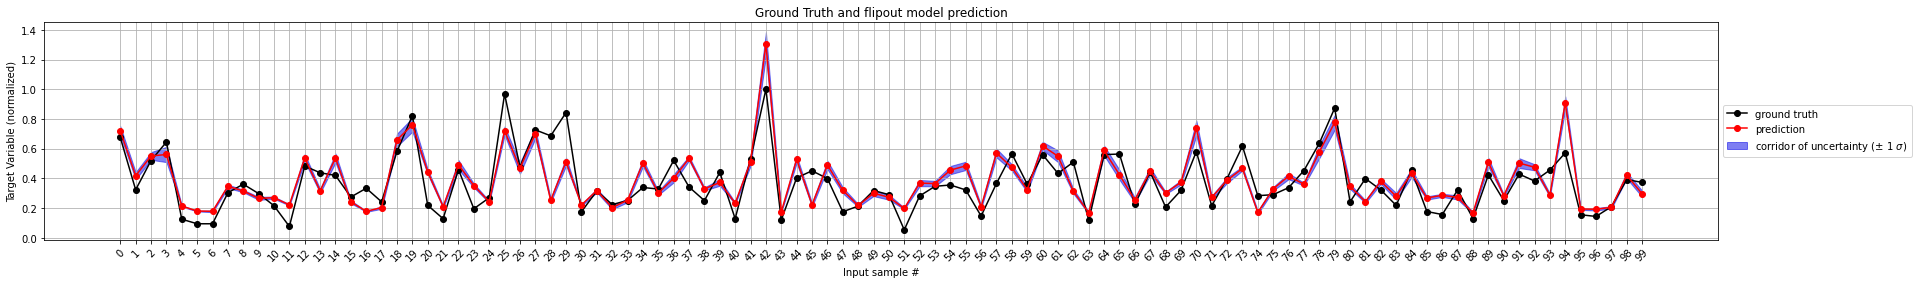

In [16]:
start_index = np.random.randint(test_data.shape[0]-150)
print('start_index \n ', start_index)

#random = range(start_index, start_index+100)
random = range(0, 100)

print('random \n ', random)

test_labels_plot= np.asarray([float(test_labels[i]) for i in random])
print('test labels plot \n ', test_labels_plot)
mean_plot = np.asarray([float(pred_mean[i]) for i in random])
std_plot = np.asarray([float(pred_std[i]) for i in random])

print('unique value of predicted standard deviation \n ', np.unique(std_plot))

plot_gt_vs_pred(test_labels_plot, mean_plot, std_plot, path+'output_plots/'+uncert_name+'_vs_prediction', random, uncert_name)

## Plot explanation function

In [17]:
# code for horizontal bar chart 

def plot_explanation(grads_plot, feature_names, sample_number=None, err=None, save_file_path=None, combination_title=None, coff=None):
    plt.figure(figsize=(8, 5))
    #plt.barh(pos, vals, color=colors) #this code works well but does not have legend or text in int

    #print('grads_plot ', grads_plot)

    colors = ['C1' if x > 0 else 'C0' for x in list(grads_plot)] # originally negative=red and positive=green (coloring scheme)
    colors_set = set(colors)
    #print('colors_set before ', colors_set)
    colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]
    #print('colors_set after ', colors_set)
    #print('exp : ', grads_plot)
    exp = list(grads_plot)
    print('feature_names ', feature_names)
    print('exp (inside plot explanation) : ', exp)
    pos = np.arange(len(exp)) + .5
    #print('pos values for plot are ', pos)

    vals = [float(x) for x in exp]
    vals_str = [str(round(val, 3)) for val in vals]
    #print('vals_str ', vals_str)

    #colors = ['r', 'g', 'b']
    labels = colors_set 
    legend_colors = list(set(colors))
    #print(legend_colors)
    handles = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
    #print(handles)

    vals = [np.abs(num) if num  == 0 else num for num in vals] # removing the sign from 0 vals
    #print('vals ', vals)

    #max_horizontal_value_to_plot_text_box = np.max(vals)

    for i, v in enumerate(vals):
        if err is None:
            #print(i, v)
            # in case the text box needs to be moved along the bar then switch 0 to v
            plt.text(v, i+0.5, str(round(v, 3)), Bbox = dict(facecolor = 'grey', alpha =0.2)) # https://www.geeksforgeeks.org/adding-value-labels-on-a-matplotlib-bar-chart/

        elif err is not None:
            # in case of the combined explanation, the text box should contain the mean+-std as well
            plt.text(v, i+0.7, str(round(v, 3))+'$\pm$'+str(round(err[i], 3)), Bbox = dict(facecolor = 'grey', alpha =0.2))

    axx = plt.barh([i for i in pos], vals, xerr=err, align='center', color=colors, alpha=0.75) # this code appropriate legend
    print('feature name before ', feature_names)
    print('grads plot before ', exp)
    #zipper = zip(feature_names, exp)

    #sorted_zipper = sorted(zipper)

    #feature_names, exp = zip(*sorted_zipper)
    #print('feature name after ', feature_names)
    #print('grads plot after ', exp) 

    plt.grid(alpha=0.5)
    plt.ylabel('feature names')
    plt.xlabel('feature coefficient')
    print('pos ', pos)

    plt.yticks(pos, feature_names)

    if err is not None:
        error = plt.plot([], label='corridor of uncertainty ($\pm \sigma$)', linewidth=3, linestyle='-', color='k')
        print('combination title[0] ', combination_title[0])
        print('combination_title[1] ', combination_title[1])
        plt.title('combined explanation , prediction : '+str(combination_title[0])+'$\pm$'+str(combination_title[1]) + ' GT : ' + str(combination_title[2]))
        main_bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        #first_legend = plt.legend(handles=error)
        #second_legend = plt.legend(handles=main_bar)

        handles = error + main_bars #https://stackoverflow.com/questions/28732845/combine-two-pyplot-patches-for-legend       
        error_label = ['corridor of uncertainty ($\pm \sigma$)']
        main_bars_label = colors_set

        labels = error_label + main_bars_label
        #plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5))
        plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)

    else:
        handles=[plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(labels))]
        plt.title(f'Explanation id {sample_number}')
        #plt.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5)) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column
        plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.1),ncol=2) # https://stackoverflow.com/questions/57340415/matplotlib-bar-plot-add-legend-from-categories-dataframe-column

    if coff:
        plt.ylabel('feature name')
        plt.title(f'{sample_number}')
        plt.xlabel('coefficient of variation ($\sigma$+$\epsilon$)/($\mu$+$\epsilon$)')
        
    plt.subplots_adjust()
    #plt.savefig(save_file_path+'_GBP.pdf', bbox_inches='tight')
    #plt.savefig(save_file_path+'_GBP.png', bbox_inches='tight')

## Compute LIME (part 1)


In [18]:
def lime_explanation_dropout(train_input, train_labels, test_input, feature_names, model, pred_fn):
    explainer = LimeTabularExplainer(training_data=train_input, 
                                     mode='regression',
                                     training_labels=train_labels, 
                                     feature_names=feature_names[:-1],
                                     verbose=True,
                                     random_state=0)


    inputs_to_be_explained = test_input.shape[0]

    #print('inputs to be explained ', inputs_to_be_explained)
    print('test input ', test_input)
    #print('test input shape ', test_input.shape)
    

    #for i in range(inputs_to_be_explained):
        #print('test_input data : ', test_input)
        #print('test_input shape ', test_input.shape)
    exp, prediction = explainer.explain_instance(data_row=test_input[0], 
                                         predict_fn=pred_fn, 
                                         num_features=8,
                                         id=0)
    print('test output ', prediction)
        
    #print('EXP OBJECT IS ', exp)
    #exp.show_in_notebook(show_table=True)
    #print('ATTRIBUTE OF THE EXPLANATIONS : ')
    #print('class names ', exp.class_names)
    #print('domain mapper ', exp.domain_mapper)
    #print('dummy label ', exp.dummy_label)
    #print('intercept ', exp.intercept)
    #print('local exp[0] ', exp.local_exp[0])
    #print('local exp[1] ', exp.local_exp[1])
    #print('local pred ', exp.local_pred)
    #print('max value ', exp.max_value)
    #print('min value ', exp.min_value)
    #print('mode ', exp.mode)
    #print('random state ', exp.random_state)
    #print('predicted value ', exp.predicted_value)
    #print('score ', exp.score)

    #print('Function values ')
    #print('HTML ')
    #print(exp.as_html(exp.dummy_label, True, True))
    #print('explanation out as list ', exp.as_list(label=exp.dummy_label))
    #exp.as_pyplot_figure(True, ensemble_component=i)
    #plt.savefig('/content/explanation_pyplot_'+str(i)+'.pdf')
    #plt.show()
    #print(f'PLOT {i} SAVED SUCCESSFULLY')
    #print(e)
    #print('explanation as map ', exp.as_map())
    #plt.clf()
    #print('COUNTER IS ', i)

    #exp.available_labels()

    return exp, exp.as_list(label=exp.dummy_label) # return the explanation object and explanation object as a list 

    #print('This explanation is generated with ', uncert_name, ' as input ')

## Compute LIME (part 2)

inputs [0] : [[0.60681115 0.18162393 0.82352941 0.04940218 0.05685804 0.06739313
  0.05580357 0.21372809]]
Intermediate samples shape  (10, 1, 1)
mean prediction  [[0.40787068]]
std prediction  [[0.02332715]]
GT  [[0.32251241]]
test input  [[0.60681115 0.18162393 0.82352941 0.04940218 0.05685804 0.06739313
  0.05580357 0.21372809]]
Intermediate samples shape  (10, 1000, 1)
predicted value 
 0.38497126
min_y value 
 0.14974223
max_y value 
 1.2453549
feature_names_here  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Intercept 0.43063739472816964
Prediction_local [0.53078606]
Right: 0.38497126
coefficients (these are the values that are printed as being the 'weights' of the feature)  [-0.10139322  0.13829372  0.08097395  0.02014886  0.00357854 -0.04475825
 -0.01916036  0.02246544]
test output  0.38497126
explanation_for_individual_input_as_list 
 {'latitude': 0.13829371940045368, 'longitude': -0.10139322406680

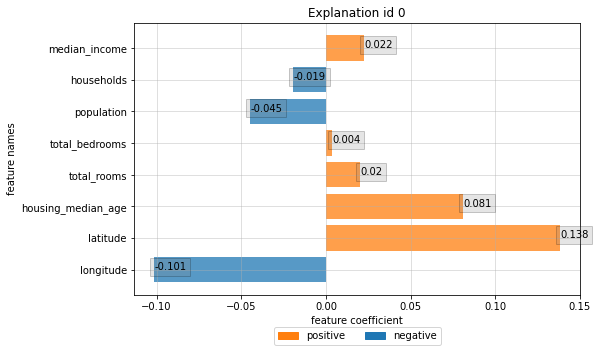

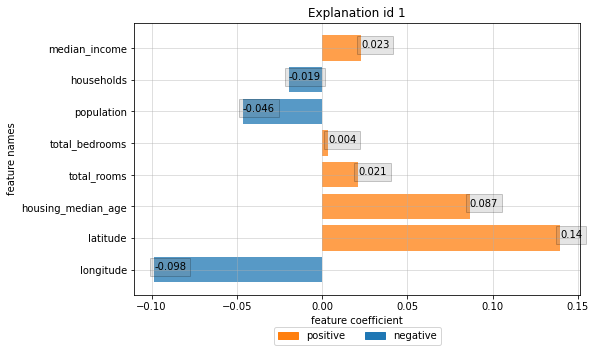

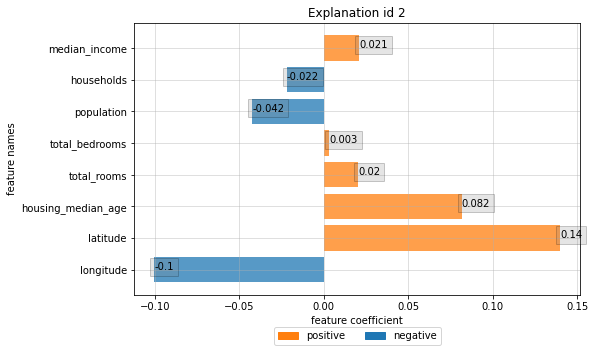

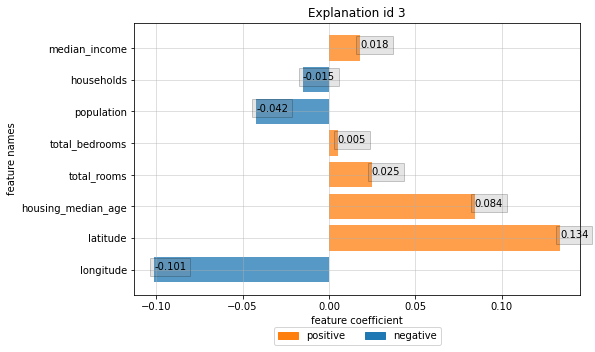

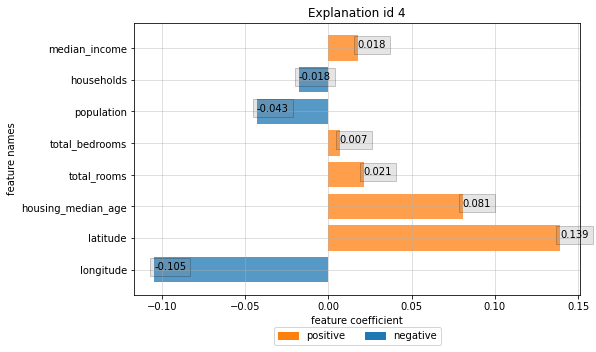

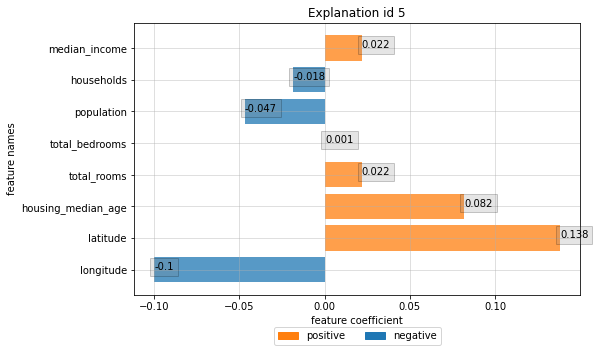

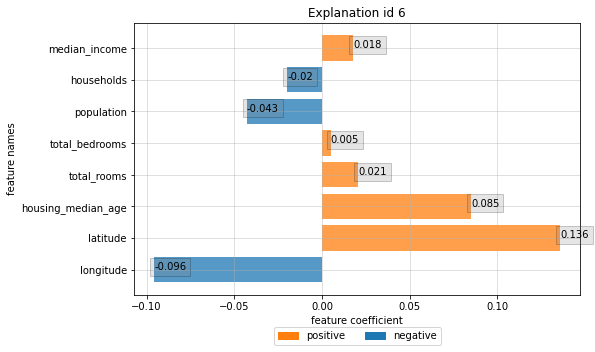

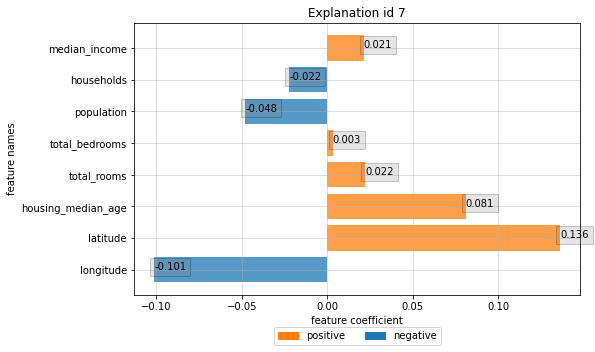

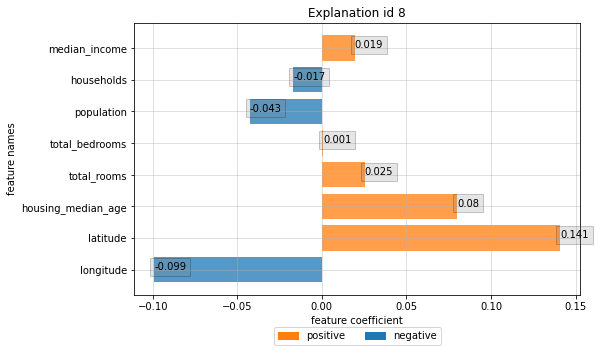

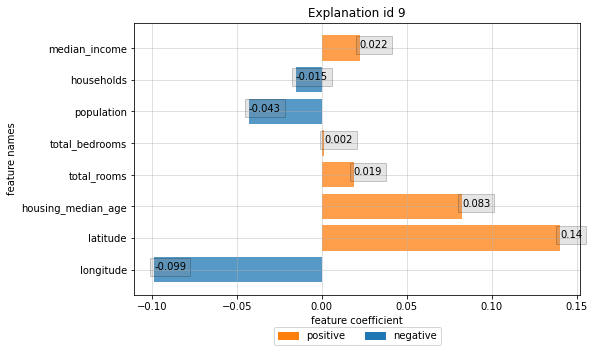

In [19]:
# drawing a sample from the distribution that is defined by the pred_mean and pred_std 
# explanation of pred_mean 

#print(test_input.shape)
#print(train_data.shape)

#count = 1

# Analysis of the input
num_of_samples_to_be_explained=1
number_of_explanations_per_input=10


#start_index = np.random.randint(0, test_data.shape[0])
start_index=1
#print('start_index : ', start_index)

test_input = test_data[start_index:start_index+num_of_samples_to_be_explained]
print('inputs [0] :', test_input)
test_gt_output = test_labels[start_index:start_index+num_of_samples_to_be_explained]
test_input_adj = np.expand_dims(test_input, axis=-1)
#print('test_input_adj shape :', test_input_adj.shape)

#print(index_of_most_extreme_inputs_to_predict)

accumulator = [] 

#for test_sample_index in range(test_data.shape[0]):

#    lime_explanation = [] 
#    component_output = [] 

    
test_input = np.expand_dims(test_data[start_index, :], axis=0)
ordered_Features = ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
for j in range(number_of_explanations_per_input):
    #model_component = StochasticRegressor(model_fn=model_function, number_of_explanations_per_input=1, models=[model[i]])   # converting each loaded model into stochastic model
    samples, mean, std = stochastic_model.predict_output(test_input)
    print('mean prediction ', mean)
    print('std prediction ', std) 
    print('GT ', test_gt_output)
    explanation_for_individual_input, explanation_for_individual_input_as_list = lime_explanation_dropout(train_data, 
                                                        train_labels, 
                                                        test_input, 
                                                        feature_names, 
                                                        stochastic_model, 
                                                        stochastic_model.predict_output)
    
                                                        
    #print('features_names_from_domain_mapper  ', explanation_for_individual_input.domain_mapper.feature_names)
    #print('score from domain_mapper ', explanation_for_individual_input.score)
    #print('GT : ' , test_labels[test_sample_index])
    explanation_for_individual_input_as_list = dict(explanation_for_individual_input_as_list)
    print('explanation_for_individual_input_as_list \n', explanation_for_individual_input_as_list)
    feature_name_and_importance = {} 

    # arrange the explanation manually
    from collections import OrderedDict

    
    print('explanation as list \n', explanation_for_individual_input_as_list)
    #7for i in range(len(explanation_for_individual_input_as_list)):
        #7feature_name_component_of_explanation_list = explanation_for_individual_input_as_list[i][0]
        #7feature_importance_component_of_explanation_list = explanation_for_individual_input_as_list[i][1]
        #7feature_name = " ".join(re.findall("[a-zA-Z]+", feature_name_component_of_explanation_list))
        #print(feature_name, feature_importance_component_of_explanation_list)
        

        #7if feature_name in feature_name_and_importance:
            # append the new number to the existing array at this slot
        #7    feature_name_and_importance[feature_name].append(feature_importance_component_of_explanation_list)
        #7else:
            # create a new array in this slot
        #7    feature_name_and_importance[feature_name] = [feature_importance_component_of_explanation_list]
    #7feature_name = list(feature_name_and_importance.keys())
    #explanation_for_individual_input_as_list = OrderedDict([(el, explanation_for_individual_input_as_list[el]) for el in ordered_Features])
    #print(explanation_for_individual_input_as_list) 
    #7print(feature_name_and_importance)
    #print('feature name ', feature_name) 

    #7exp = list(feature_name_and_importance.values())
    #7exp_l = [x for xs in exp for x in xs]
    #print('exp ', exp_l)
    #7accumulator.append(exp_l) 
    from collections import OrderedDict

    sorted_explanation_for_individual_input_as_list = OrderedDict([(el, explanation_for_individual_input_as_list[el]) for el in ordered_Features])   
    print(sorted_explanation_for_individual_input_as_list.keys())
    print(sorted_explanation_for_individual_input_as_list.values())

    accumulator.append(list(sorted_explanation_for_individual_input_as_list.values()))
    plot_explanation(sorted_explanation_for_individual_input_as_list.values(),
                     sorted_explanation_for_individual_input_as_list.keys(),
                     sample_number=j,
                     err=None,
                     save_file_path=explanation_heatmap_path+'/input_id_'+str(start_index)+'_explanation_instance_'+str(j), 
                     combination_title=None
                         )    
    #print('ATTRIBUTE OF THE EXPLANATIONS : ')
    #print('class names ', explanation_for_individual_input.class_names)
    #print('domain mapper ', explanation_for_individual_input.domain_mapper)
    #print('dummy label ', explanation_for_individual_input.dummy_label)
    #print('intercept ', explanation_for_individual_input.intercept)
    #print('local exp[0] ', explanation_for_individual_input.local_exp[0])
    #print('local exp[1] ', explanation_for_individual_input.local_exp[1])
    #print('local pred ', explanation_for_individual_input.local_pred)
    #print('max value ', explanation_for_individual_input.max_value)
    #print('min value ', explanation_for_individual_input.min_value)
    #print('mode ', explanation_for_individual_input.mode)
    #print('random state ', explanation_for_individual_input.random_state)
    #print('predicted value ', explanation_for_individual_input.predicted_value)
    #print('score ', explanation_for_individual_input.score)

    #print('Function values ')
    
    #print('explanation ID \n ', i)
    #print('feature_name_and_importance \n ', feature_name_and_importance)
    #print('feature weights \n ', feature_name_and_importance.values())
    print('xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx')
#print('TEST SAMPLE ID ', test_sample_index)

# generate explanation for one input (easier debugging) 
#print('component_output ', component_output)                                                            
#lime_explanation.append(sample_exp)
#component_output.append(sample_outp)
#plot_explanation(sample_exp.squeeze(axis=0),
    #                 feature_names,
    #                 sample_number=i,
    #                 err=None,
    #                 save_file_path=path+'output_plots/explanation_for_component_number_'+str(i)+'_input_id_'+str(test_sample_index)+'_'+difficulty,
    #                 combination_title=None)
    
#print('feature_name ', feature_names)
#print('test input ', test_input)
#print('prediction sample ', ensemble_model.generate_sample_from_predicted_mean_and_std(test_input_adj))

## Mean and Std

0.021463715
feature_names  odict_keys(['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])
exp (inside plot explanation) :  [-0.10001272430598562, 0.13816795048930344, 0.08246999580119277, 0.021682477867268388, 0.003303461852176757, -0.04421938294693583, -0.018594784851703024, 0.02050976778557916]
feature name before  odict_keys(['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income'])
grads plot before  [-0.10001272430598562, 0.13816795048930344, 0.08246999580119277, 0.021682477867268388, 0.003303461852176757, -0.04421938294693583, -0.018594784851703024, 0.02050976778557916]
pos  [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5]
combination title[0]  0.418
combination_title[1]  0.02146


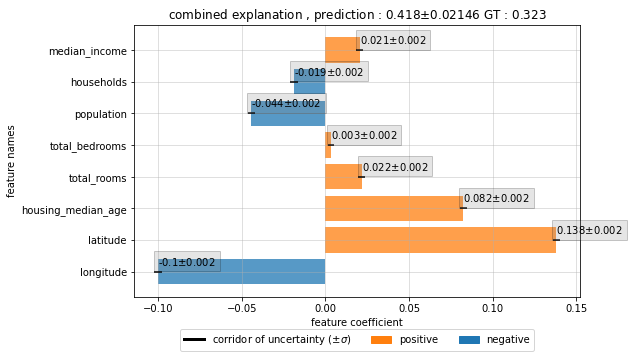

In [20]:
accumulator_arr = np.array(accumulator)
mean_weight = np.mean(accumulator_arr, axis=0)
std_weight = np.std(accumulator_arr, axis=0)


mean_prediction = np.mean(samples)
mean_prediction_rounded = round(mean_prediction, 3)
#print('mean prediction rounded ', mean_prediction_rounded)

std_prediction = np.std(samples)
print(std_prediction)
std_prediction_rounded = round(std_prediction, 5)
#print(std_prediction_rounded)

#print(list_of_inputs_gt[exp])
ground_truth = round(test_gt_output[0][0], 3)

plot_explanation(mean_weight, 
                 sorted_explanation_for_individual_input_as_list.keys(), 
                 err=std_weight, #
                 save_file_path=None,
                 combination_title=[mean_prediction_rounded, std_prediction_rounded, ground_truth])

## Coefficient of Variation

feature_names  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
exp (inside plot explanation) :  [-0.13608456818029818, 0.08216346565919733, 0.13008279393539285, 0.37508046744239437, 0.8949768754426085, -0.3530922257367611, -1.4310857897986635, 0.38999870166477896]
feature name before  ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value']
grads plot before  [-0.13608456818029818, 0.08216346565919733, 0.13008279393539285, 0.37508046744239437, 0.8949768754426085, -0.3530922257367611, -1.4310857897986635, 0.38999870166477896]
pos  [0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5]


<Figure size 576x360 with 0 Axes>

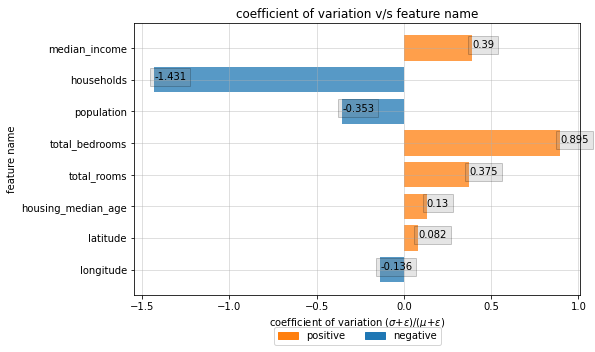

In [21]:
stabilizer=0.01
coefficient_of_variation = [(i+stabilizer)/(j+stabilizer) for i,j in zip(std_weight, mean_weight)]

plt.figure(figsize=(8, 5))
colors = ['C1' if x > 0 else 'C0' for x in list(coefficient_of_variation)] # originally negative=red and positive=green (coloring scheme)
colors_set = set(colors)
legend_colors = list(set(colors))
colors_set = ['positive' if c == 'C1' else 'negative' for c in colors_set]

bars = [plt.Rectangle((0,0),1,1, color=legend_colors[label]) for label in range(len(colors_set))]
#uncomment the next 2 line in case cv threshold is needed 
#thresh = plt.plot([], label='threshold', linewidth=3, linestyle='-', color='k')
#handles = bars + thresh

main_bars_label = colors_set

# uncomment following two lines in case cv threshold is needed
#error_label = ['threshold']
#labels = main_bars_label + error_label 

# uncomment following two lines to remove threshold
handles = bars 
labels = main_bars_label

plot_explanation(coefficient_of_variation, 
                     feature_names, 
                     sample_number="coefficient of variation v/s feature name", 
                     
                     save_file_path=None,
                     combination_title='coefficient of variation',
                     coff=True)